In [2]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
from sklearn import metrics, random_projection
from scipy import linalg, stats

import utils

sns.set()

In [3]:
# CCD Dataset
ccd = pd.read_csv("datasets/UCI_Credit_Card.csv", header=0)
feature_cols = [col for col in ccd.columns if col != 'ID' and col != 'default.payment.next.month']
ccd_features_df = ccd[feature_cols]
ccd_target = ccd['default.payment.next.month']

col_names = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
scaled_cols = [x for x in list(ccd_features_df) if x not in col_names]
ccd_features_df = pd.get_dummies(ccd_features_df, columns=col_names)


column_trans = make_column_transformer(
    (MinMaxScaler(), scaled_cols),
    remainder='passthrough'
)

ccd_features = column_trans.fit_transform(ccd_features_df)
ccd_features.shape

(30000, 91)

In [4]:
# FMA Dataset
tracks = utils.load('datasets/fma_metadata/tracks.csv')
features_csv = utils.load('datasets/fma_metadata/features.csv')

subset = tracks['set', 'subset'] <= 'medium'
fma_target = tracks.loc[subset, ('track', 'genre_top')]

encoder = LabelEncoder()
fma_target_encoded = encoder.fit_transform(fma_target)

#fma_features_df = features_csv.loc[subset, ['mfcc', 'spectral_rolloff', 'spectral_contrast']]
fma_features_df = features_csv.loc[subset]

scaler = MinMaxScaler()
fma_features = scaler.fit_transform(fma_features_df)

print(fma_features.shape)

(25000, 518)


In [212]:
for i, label in enumerate(encoder.inverse_transform(range(16))):
    print(i, label)

0 Blues
1 Classical
2 Country
3 Easy Listening
4 Electronic
5 Experimental
6 Folk
7 Hip-Hop
8 Instrumental
9 International
10 Jazz
11 Old-Time / Historic
12 Pop
13 Rock
14 Soul-RnB
15 Spoken


In [153]:
ccd_tsne_perplexity = 173
fma_tsne_perplexity = 158

## PCA

### CCD

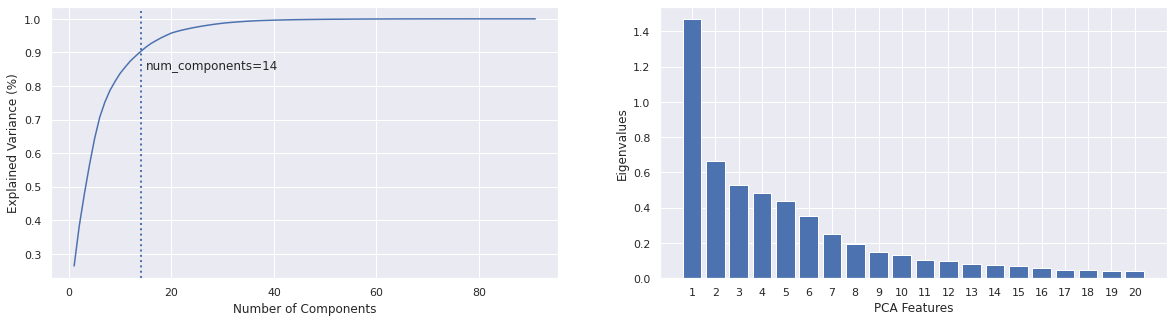

In [65]:
# Fitting the PCA algorithm with our Data
# https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
ccd_pca = PCA().fit(ccd_features)
ccd_cum_evr = np.cumsum(ccd_pca.explained_variance_ratio_)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(range(1, len(ccd_cum_evr) + 1), ccd_cum_evr)
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Explained Variance (%)') #for each component
ax[0].axvline(14, linestyle=':', linewidth = 2)
ax[0].text(15, 0.85, 'num_components=14')
#ax[0].grid(b=True, which='major', color='grey', linestyle='-')

ccd_pca = PCA(n_components=20).fit(ccd_features)
features = range(1, pca.n_components_ + 1)
ax[1].bar(features, pca.explained_variance_)
ax[1].set_xlabel('PCA Features')
ax[1].set_ylabel('Eigenvalues')
#ax[1].grid(b=True, which='major', color='grey', linestyle='-')
ax[1].set_xticks(features)
plt.show()

In [61]:
ccd_pca = PCA(n_components=2, random_state=23)
ccd_pca_features = ccd_pca.fit_transform(ccd_features)

print(pd.DataFrame(ccd_pca.components_, columns=ccd_features_df.columns, index=['PC-1','PC-2']).abs().idxmax(axis=1))

PC-1     PAY_3_0
PC-2    PAY_5_-2
dtype: object


In [62]:
print(ccd_features_df.columns.get_loc('PAY_3_0'), ccd_features_df.columns.get_loc('PAY_5_-2'))

51 71


14


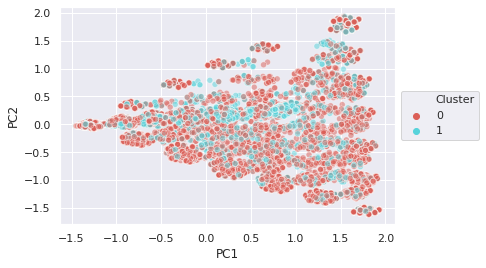

In [63]:
ccd_n_components = np.argwhere(cum_evr > 0.9)[0][0] + 1
print(ccd_n_components)

# https://cmdlinetips.com/2018/03/pca-example-in-python-with-scikit-learn/
ccd_pca = PCA(n_components=ccd_n_components, random_state=23)
ccd_pca_features = ccd_pca.fit_transform(ccd_features)

ccd_pc_df = pd.DataFrame(data=ccd_pca_features, columns=["PC%d" % i for i in range(1, ccd_n_components + 1)])
ccd_pc_df['Cluster'] = ccd_target
ccd_pc_df.head()

g = sns.scatterplot(x="PC1", y="PC2", data=ccd_pc_df, 
                    palette=sns.color_palette("hls", 2), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

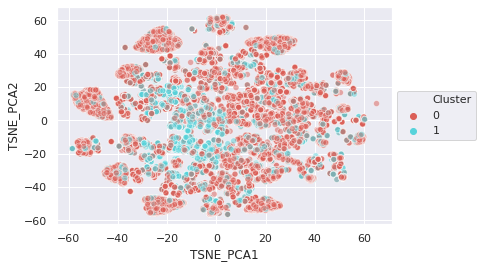

In [166]:
ccd_pca_tsne = TSNE(n_components=2, random_state=23, n_jobs=-1, perplexity=ccd_tsne_perplexity)
ccd_pca_tsne_features = ccd_pca_tsne.fit_transform(ccd_pca_features)

ccd_pca_df = pd.DataFrame(data=ccd_pca_tsne_features, columns=["TSNE_PCA%d" % i for i in range(1, 2 + 1)])
ccd_pca_df['Cluster'] = ccd_target

g = sns.scatterplot(x="TSNE_PCA1", y="TSNE_PCA2", data=ccd_pca_df, 
                    palette=sns.color_palette("hls", 2), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

### FMA

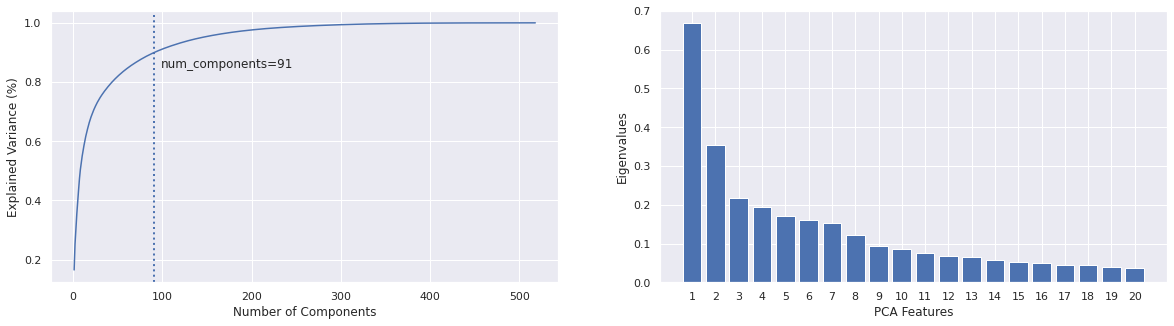

In [70]:
# Fitting the PCA algorithm with our Data
# https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
fma_pca = PCA().fit(fma_features)
fma_cum_evr = np.cumsum(fma_pca.explained_variance_ratio_)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(range(1, len(fma_cum_evr) + 1), fma_cum_evr)
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Explained Variance (%)') #for each component
ax[0].axvline(91, linestyle=':', linewidth = 2)
ax[0].text(98, 0.85, 'num_components=91')
ax[0].grid(b=True, which='minor', color='black', linestyle='-')

fma_pca = PCA(n_components=20).fit(fma_features)
features = range(1, fma_pca.n_components_ + 1)
ax[1].bar(features, fma_pca.explained_variance_)
ax[1].set_xlabel('PCA Features')
ax[1].set_ylabel('Eigenvalues')
ax[1].grid(b=True, which='minor', color='black', linestyle='-')
ax[1].set_xticks(features)
plt.show()

In [172]:
fma_pca = PCA(n_components=2, random_state=23)
fma_pca_features = fma_pca.fit_transform(fma_features)

fma_pca_cols = pd.DataFrame(fma_pca.components_, columns=fma_features_df.columns, index=['PC-1','PC-2']).idxmax(axis=1)
print(fma_pca_cols)

PC-1      (chroma_stft, median, 05)
PC-2    (spectral_rolloff, std, 01)
dtype: object


Text(0.5, 0, 'Features')

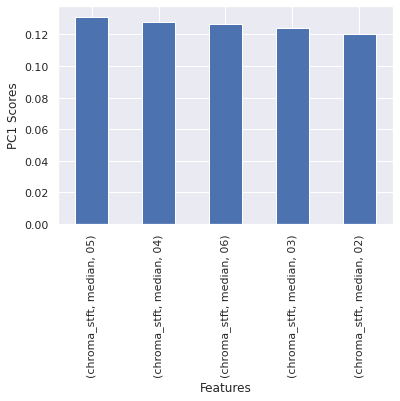

In [216]:
series = pd.DataFrame(fma_pca.components_, columns=fma_features_df.columns).iloc[0].abs().sort_values(ascending=False)
series = series.iloc[:5]
series.plot.bar()
plt.ylabel('PC1 Scores')
plt.xlabel('Features')

Text(0.5, 0, 'Features')

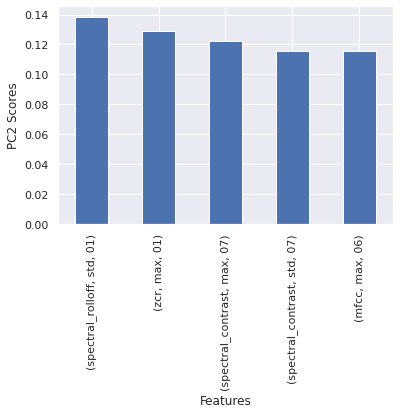

In [217]:
series = pd.DataFrame(fma_pca.components_, columns=fma_features_df.columns).iloc[1].abs().sort_values(ascending=False)
series = series.iloc[:5]
series.plot.bar()
plt.ylabel('PC2 Scores')
plt.xlabel('Features')

In [173]:
print(fma_features_df.columns.get_loc(fma_pca_cols[0]), 
      fma_features_df.columns.get_loc(fma_pca_cols[1]))

208 468


91


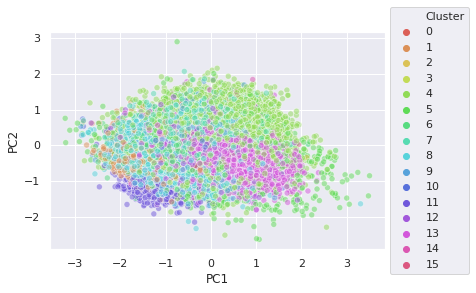

In [25]:
# https://cmdlinetips.com/2018/03/pca-example-in-python-with-scikit-learn/
fma_pca_num = np.argwhere(fma_cum_evr > 0.9)[0][0] + 1
print(fma_pca_num)

fma_pca = PCA(n_components=fma_pca_num, random_state=23)
fma_pca_features = fma_pca.fit_transform(fma_features)

fma_pc_df = pd.DataFrame(data=fma_pca_features, columns=["PC%d" % i for i in range(1, fma_pca_num + 1)])
fma_pc_df['Cluster'] = fma_target_encoded
fma_pc_df.head()

g = sns.scatterplot(x="PC1", y="PC2", data=fma_pc_df, 
                    palette=sns.color_palette("hls", 16), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

In [ ]:
fma_pca_tsne = TSNE(n_components=2, random_state=23, n_jobs=-1, perplexity=fma_tsne_perplexity)
fma_pca_tsne_features = fma_pca_tsne.fit_transform(fma_pca_features)

fma_pca_df = pd.DataFrame(data=fma_pca_tsne_features, columns=["TSNE_PCA%d" % i for i in range(1, 2 + 1)])

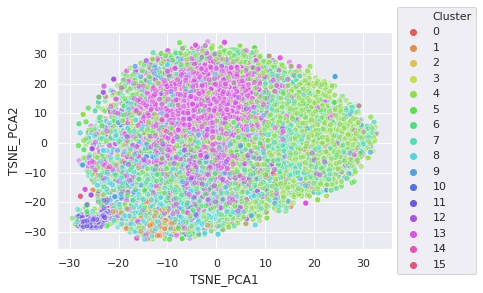

In [169]:
fma_pca_df['Cluster'] = fma_target_encoded

g = sns.scatterplot(x="TSNE_PCA1", y="TSNE_PCA2", data=fma_pca_df, 
                    palette=sns.color_palette("hls", 16), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

## ICA

### CCD

In [11]:
ccd_kurtosis = []
ccd_ica_fits = []

for i in range(1, 92):
    ccd_ica = FastICA(random_state=23, n_components=i, max_iter=500).fit(ccd_features)
    ccd_ica_fits.append(ccd_ica)
    ccd_kurtosis.append(np.average(np.abs(stats.kurtosis(ccd_ica.components_))))

/home/clement/.local/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/clement/.local/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/clement/.local/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/clement/.local/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/clement/.local/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: 

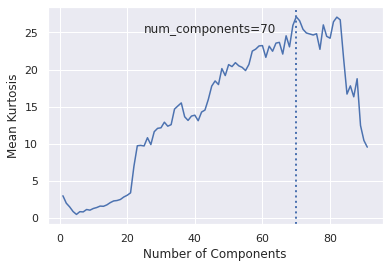

27.112401937526837
70


In [94]:
plt.figure()
plt.plot(range(1, len(ccd_kurtosis) + 1), ccd_kurtosis)
plt.xlabel('Number of Components')
plt.ylabel('Mean Kurtosis') #for each component
ccd_ica_n_components = ccd_kurtosis.index(max(ccd_kurtosis)) + 1
plt.axvline(ccd_ica_n_components, linestyle=':', linewidth = 2)
plt.text(25, 25, "num_components=%d" % ccd_ica_n_components)
plt.show()

ccd_ica_n_components = ccd_kurtosis.index(max(ccd_kurtosis)) + 1
print(max(ccd_kurtosis))
print(ccd_ica_n_components)

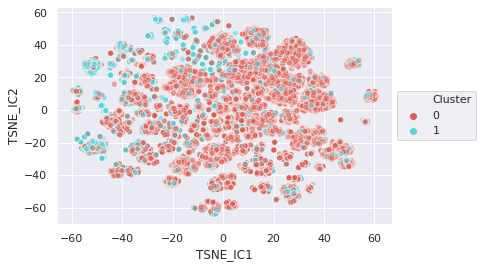

In [154]:
# https://cmdlinetips.com/2018/03/pca-example-in-python-with-scikit-learn/
ccd_ica = FastICA(n_components=ccd_ica_n_components, random_state=23)
ccd_ica_features = ccd_ica.fit_transform(ccd_features)
ccd_ica_tsne = TSNE(n_components=2, random_state=23, n_jobs=-1, perplexity=ccd_tsne_perplexity)
ccd_ica_tsne_features = ccd_ica_tsne.fit_transform(ccd_ica_features)

ccd_ic_df = pd.DataFrame(data=ccd_ica_tsne_features, columns=["TSNE_IC%d" % i for i in range(1, 2 + 1)])
ccd_ic_df['Cluster'] = ccd_target
ccd_ic_df.head()

g = sns.scatterplot(x="TSNE_IC1", y="TSNE_IC2", data=ccd_ic_df, 
                    palette=sns.color_palette("hls", 2), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

### FMA 

In [81]:
fma_ica = FastICA(random_state=23).fit(fma_features)
fma_kurtosis = [stats.kurtosis(x) for x in fma_ica.components_]

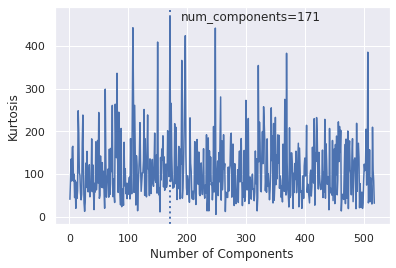

468.4015408446386
171


In [93]:
plt.figure()
plt.plot(range(1, len(fma_kurtosis) + 1), fma_kurtosis)
plt.xlabel('Number of Components')
plt.ylabel('Kurtosis') #for each component
plt.axvline(171, linestyle=':', linewidth = 2)
plt.text(190, 460, 'num_components=171')
plt.show()

fma_ica_components = fma_kurtosis.index(max(fma_kurtosis)) + 1
print(max(fma_kurtosis))
print(fma_ica_components)

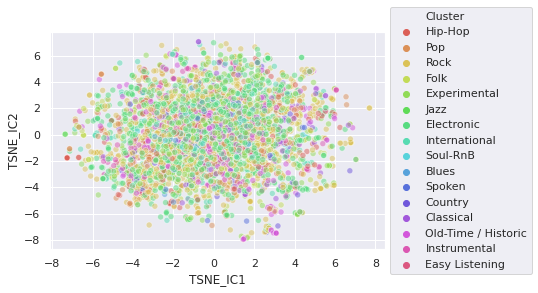

In [157]:
# https://cmdlinetips.com/2018/03/pca-example-in-python-with-scikit-learn/
fma_ica = FastICA(n_components=fma_ica_components, random_state=23)
fma_ica_features = fma_ica.fit_transform(fma_features)
fma_ica_tsne = TSNE(n_components=2, random_state=23, n_jobs=-1, perplexity=fma_tsne_perplexity)
fma_ica_tsne_features = fma_ica_tsne.fit_transform(fma_ica_features)

fma_ic_df = pd.DataFrame(data=fma_ica_tsne_features, columns=["TSNE_IC%d" % i for i in range(1, 2 + 1)])
fma_ic_df['Cluster'] = fma_target
fma_ic_df.head()

g = sns.scatterplot(x="TSNE_IC1", y="TSNE_IC2", data=fma_ic_df, 
                    palette=sns.color_palette("hls", 16), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

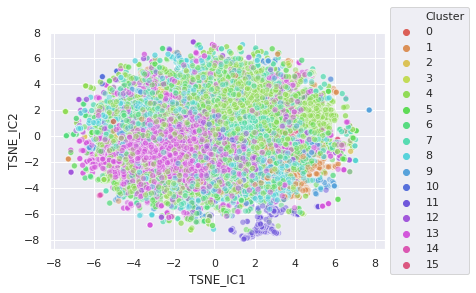

In [162]:
fma_ic_df['Cluster'] = fma_target_encoded
fma_ic_df.head()

g = sns.scatterplot(x="TSNE_IC1", y="TSNE_IC2", data=fma_ic_df, 
                    palette=sns.color_palette("hls", 16), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

## Randomized Projection

### CCD

In [111]:
print("Calculating Reconstruction Error")

def inverse_transform_rp(rp, x_transformed, x_train):
    return x_transformed.dot(rp.components_) + np.mean(x_train, axis = 0)

runs = range(10)
n_components = range(1, 92)
ccd_reconstruction_error = [[] for i in range(10)]
ccd_rp_n_components = []
ccd_rp = []

for i in runs:
    for comp in n_components:
        rp = random_projection.GaussianRandomProjection(n_components=comp)
        ccd_rp.append(rp)
        x_transformed = rp.fit_transform(ccd_features)
        x_projected = inverse_transform_rp(rp, x_transformed, ccd_features)
        ccd_reconstruction_error[i].append(((ccd_features - x_projected) ** 2).mean())
    ccd_rp_n_components.append(np.argwhere(np.array(ccd_reconstruction_error[i]) <= 1.0)[0][0])

Calculating Reconstruction Error


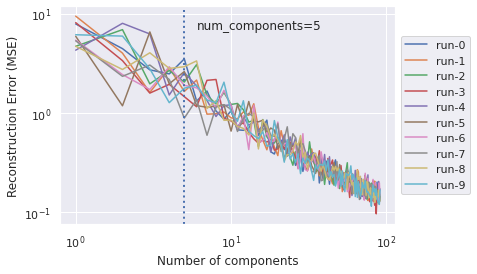

In [121]:
ccd_rp_lowest_n = np.amin(ccd_rp_n_components) + 1
fig,ax = plt.subplots()
for i in runs:
    ax.loglog(n_components, ccd_reconstruction_error[i], linestyle='-', label="run-%d" % i)
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error (MSE)')
ax.axvline(ccd_rp_lowest_n, linestyle=':', linewidth = 2)
ax.text(ccd_rp_lowest_n + 1, 7, 'num_components=' + str(ccd_rp_lowest_n))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#ax.set_ylim(0, 10)
plt.show()

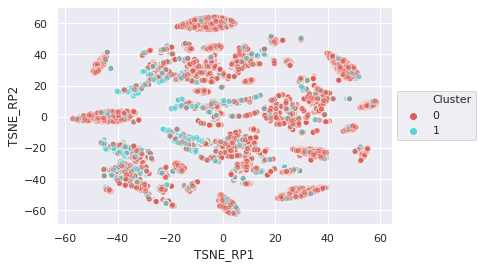

In [158]:
# https://cmdlinetips.com/2018/03/pca-example-in-python-with-scikit-learn/
ccd_rp = FastICA(n_components=ccd_rp_lowest_n, random_state=23)
ccd_rp_features = ccd_rp.fit_transform(ccd_features)
ccd_rp_tsne = TSNE(n_components=2, random_state=23, n_jobs=-1, perplexity=ccd_tsne_perplexity)
ccd_rp_tsne_features = ccd_rp_tsne.fit_transform(ccd_rp_features)

ccd_rp_df = pd.DataFrame(data=ccd_rp_tsne_features, columns=["TSNE_RP%d" % i for i in range(1, 2 + 1)])
ccd_rp_df['Cluster'] = ccd_target

g = sns.scatterplot(x="TSNE_RP1", y="TSNE_RP2", data=ccd_rp_df, 
                    palette=sns.color_palette("hls", 2), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

### FMA

In [102]:
print("Calculating Reconstruction Error")

def inverse_transform_rp(rp, x_transformed, x_train):
    return x_transformed.dot(rp.components_) + np.mean(x_train, axis = 0)

runs = range(10)
n_components = range(1, 519)
reconstruction_error = [[] for i in range(10)]
fma_rp_n_components = []
fma_rp = []

for i in runs:
    for comp in n_components:
        rp = random_projection.GaussianRandomProjection(n_components=comp)
        fma_rp.append(rp)
        x_transformed = rp.fit_transform(fma_features)
        x_projected = inverse_transform_rp(rp, x_transformed, fma_features)
        reconstruction_error[i].append(((fma_features - x_projected) ** 2).mean())
    fma_rp_n_components.append(np.argwhere(np.array(reconstruction_error[i]) <= 1.0)[0][0])

Calculating Reconstruction Error


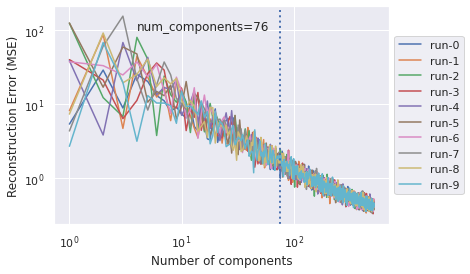

In [122]:
fma_rp_lowest_n = np.amin(fma_rp_n_components) + 1
fig,ax = plt.subplots()
for i in runs:
    ax.loglog(range(1, 519), reconstruction_error[i], linestyle='-', label="run-%d" % i)
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error (MSE)')
ax.axvline(fma_rp_lowest_n, linestyle=':', linewidth = 2)
ax.text(4, 100, 'num_components=' + str(fma_rp_lowest_n))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
#ax.set_ylim(0, 10)
plt.show()

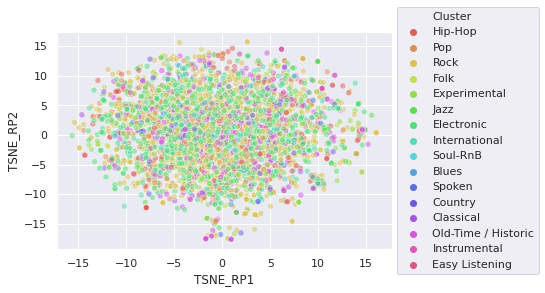

In [161]:
# https://cmdlinetips.com/2018/03/pca-example-in-python-with-scikit-learn/
fma_rp = FastICA(n_components=fma_rp_lowest_n, random_state=23)
fma_rp_features = fma_rp.fit_transform(fma_features)
fma_rp_tsne = TSNE(n_components=2, random_state=23, n_jobs=-1, perplexity=fma_tsne_perplexity)
fma_rp_tsne_features = fma_rp_tsne.fit_transform(fma_rp_features)

fma_rp_df = pd.DataFrame(data=fma_rp_tsne_features, columns=["TSNE_RP%d" % i for i in range(1, 2 + 1)])
fma_rp_df['Cluster'] = fma_target

g = sns.scatterplot(x="TSNE_RP1", y="TSNE_RP2", data=fma_rp_df, 
                    palette=sns.color_palette("hls", 16), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

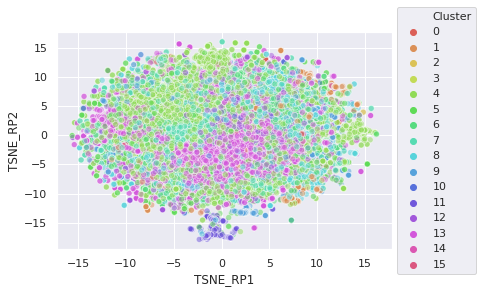

In [163]:
fma_rp_df['Cluster'] = fma_target_encoded
g = sns.scatterplot(x="TSNE_RP1", y="TSNE_RP2", data=fma_rp_df, 
                    palette=sns.color_palette("hls", 16), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

## LDA

In [133]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
ccd_lda = LinearDiscriminantAnalysis(n_components=1)
ccd_lda.fit(ccd_features, ccd_target)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

Text(8, 0.85, 'num_components=7')

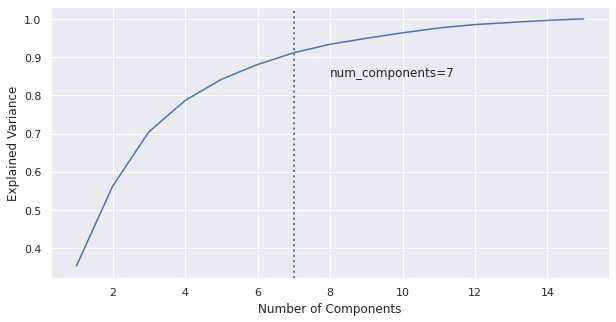

In [152]:
fma_lda = LinearDiscriminantAnalysis().fit(fma_features, fma_target)
fma_lda_cum_evr = np.cumsum(fma_lda.explained_variance_ratio_)
fma_lda_n_components = np.argwhere(fma_lda_cum_evr > 0.9)[0][0] + 1

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(fma_lda_cum_evr) + 1), fma_lda_cum_evr)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance') #for each component
plt.axvline(fma_lda_n_components, linestyle=':', linewidth = 2)
plt.text(fma_lda_n_components + 1, 0.85, "num_components=%d" % fma_lda_n_components)

In [142]:
#Credit: https://stackoverflow.com/questions/42957962/linear-discriminant-analysis-inverse-transform
print("Calculating Reconstruction Error")

from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y

def inverse_transform_lda(lda, x, n):
    if lda.solver == 'lsqr':
        raise NotImplementedError("(inverse) transform not implemented for 'lsqr' "
                                  "solver (use 'svd' or 'eigen').")
    check_is_fitted(lda, ['xbar_', 'scalings_'], all_or_any=any)

    inv = np.linalg.pinv(lda.scalings_)[:n]

    x = check_array(x)
    if lda.solver == 'svd':
        x_back = np.dot(x, inv) + lda.xbar_
    elif lda.solver == 'eigen':
        x_back = np.dot(x, inv)

    return x_back

n_components = range(1, 16)
reconstruction_error = []
fma_lda_n_components = []
fma_lda = []

for comp in n_components:
    lda = LinearDiscriminantAnalysis(n_components=comp)
    fma_lda.append(lda)
    x_transformed = lda.fit_transform(fma_features, fma_target)
    x_projected = inverse_transform_lda(lda, x_transformed, comp)
    reconstruction_error.append(((fma_features - x_projected) ** 2).mean())

Calculating Reconstruction Error


[0.007813490008850305, 0.00781259083496564, 0.007811537035089886, 0.007810558974126931, 0.00781017548566159, 0.007809858301923311, 0.007809416020708688, 0.007809232683128115, 0.00780911881212893, 0.007808835870117597, 0.007808674527144113, 0.007808507596469627, 0.007808382565880349, 0.0078081891124333344, 0.007808022605895719]


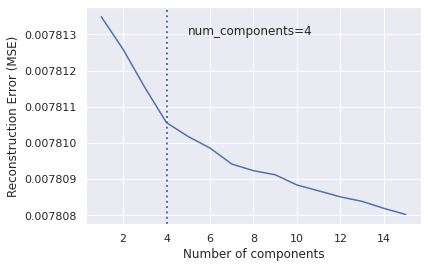

In [144]:
print(reconstruction_error)
fig,ax = plt.subplots()

ax.plot(range(1, 16), reconstruction_error, linestyle='-')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error (MSE)')
ax.axvline(4, linestyle=':', linewidth = 2)
ax.text(5, 0.007813, 'num_components=' + str(4))
#ax.set_ylim(0, 10)
plt.show()

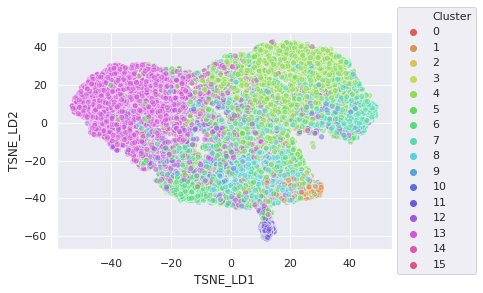

In [165]:
# https://cmdlinetips.com/2018/03/pca-example-in-python-with-scikit-learn/
fma_lda = LinearDiscriminantAnalysis(n_components=4)
fma_lda_features = fma_lda.fit_transform(fma_features, fma_target)
fma_lda_tsne = TSNE(n_components=2, random_state=23, n_jobs=-1, perplexity=fma_tsne_perplexity)
fma_lda_tsne_features = fma_lda_tsne.fit_transform(fma_lda_features)

fma_lda_df = pd.DataFrame(data=fma_lda_tsne_features, columns=["TSNE_LD%d" % i for i in range(1, 2 + 1)])
fma_lda_df['Cluster'] = fma_target_encoded

g = sns.scatterplot(x="TSNE_LD1", y="TSNE_LD2", data=fma_lda_df, 
                    palette=sns.color_palette("hls", 16), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

## TSNE

### CCD

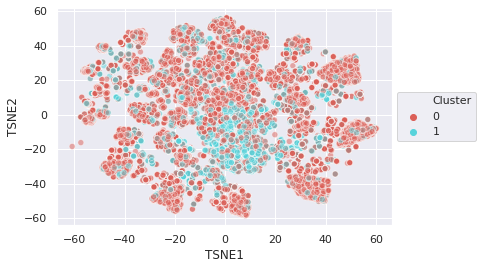

In [128]:
ccd_tsne_components = 2
ccd_tsne = TSNE(n_components=ccd_tsne_components, random_state=23, n_jobs=-1, perplexity=173)

ccd_tsne_features = ccd_tsne.fit_transform(ccd_features)

ccd_tsne_df = pd.DataFrame(data=ccd_tsne_features, columns=["TSNE%d" % i for i in range(1, ccd_tsne_components + 1)])
ccd_tsne_df['Cluster'] = ccd_target
ccd_tsne_df.head()

g = sns.scatterplot(x="TSNE1", y="TSNE2", data=ccd_tsne_df, 
                    palette=sns.color_palette("hls", 2), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

### FMA

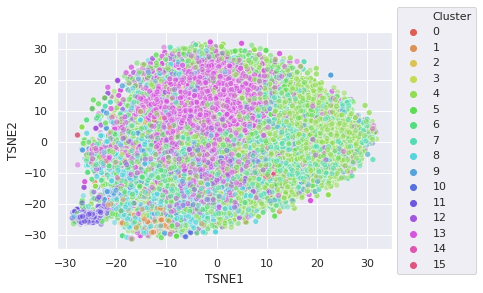

In [129]:
fma_tsne_components = 2
fma_tsne = TSNE(n_components=fma_tsne_components, random_state=23, n_jobs=-1, perplexity=158)

fma_tsne_features = fma_tsne.fit_transform(fma_features)

fma_tsne_df = pd.DataFrame(data=fma_tsne_features, columns=["TSNE%d" % i for i in range(1, fma_tsne_components + 1)])

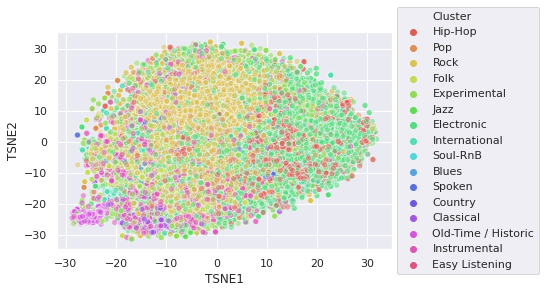

In [213]:
fma_tsne_df['Cluster'] = encoder.inverse_transform(fma_target_encoded)
fma_tsne_df.head()

g = sns.scatterplot(x="TSNE1", y="TSNE2", data=fma_tsne_df, 
                    palette=sns.color_palette("hls", 16), 
                    hue='Cluster', legend='brief', alpha=0.5)
g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)